In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notebook for catboost model development and testing

scores, frequency 15min: 
training on observed data only 
- 173 med objective="MultiRSME", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"
- 171 med objective="MAE", learning_rate=0.10931167365445349, colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"
- 180 med vanlig catboost, trent på time series data. 

training on both observed and estimated 


TRAINING ON HOURLY DATA 

159 - using normal catboost


168 - using catboost with objective="MAE", learning_rate=0.10931167365445349 colsample_bylevel=0.09963123954233088, max_depth=15, boosting_type="Plain", bootstrap_type="MVS"



## Getting data


## Training on combined observed and estimated data

In [50]:
%store -r dm 

from sklearn.model_selection import train_test_split

dm = dm

X_A_train = dm.data_A.iloc[:, 3:-1]
y_A_train = dm.data_A.iloc[:,0]
X_B_train = dm.data_B.iloc[:, 3:-1]
y_B_train = dm.data_B.iloc[:,0]
X_C_train = dm.data_C.iloc[:, 3:-1]
y_C_train = dm.data_C.iloc[:,0]


X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A_train, y_A_train, shuffle=False, train_size=0.9)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B_train, y_B_train, shuffle=False, train_size=0.9)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C_train, y_C_train, shuffle=False, train_size=0.9)

X_A_submission = dm.X_test_estimated_a[dm.X_test_estimated_a.columns.intersection(X_A_train.columns)]
X_B_submission = dm.X_test_estimated_b[dm.X_test_estimated_b.columns.intersection(X_B_train.columns)]
X_C_submission = dm.X_test_estimated_c[dm.X_test_estimated_c.columns.intersection(X_C_train.columns)]

print(X_train_A.shape, y_train_A.shape, X_test_A.shape, y_test_A.shape)
print(X_train_B.shape, y_train_B.shape, X_test_B.shape, y_test_B.shape)
print(X_train_C.shape, y_train_C.shape, X_test_C.shape, y_test_C.shape)

X_A_train



(30653, 44) (30653,) (3406, 44) (3406,)
(25097, 44) (25097,) (2789, 44) (2789,)
(20009, 44) (20009,) (2224, 44) (2224,)


,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,...,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,month,hours,week_number,day_year
0,1.22825,0.000000,0.000,0.0,280.299988,0.000000,0.000000,0.000,0.000000,99.074997,...,100.000000,40386.476562,3.600,-3.575,-0.500,0.0,12.0,1.607695,49.021857,341.969796
1,1.22350,0.000000,0.000,0.0,280.299988,0.000000,0.000000,0.000,0.000000,99.750000,...,100.000000,33770.648438,3.350,-3.350,0.275,0.0,12.0,0.408890,49.021857,341.969796
2,1.21975,0.000000,0.000,0.0,280.649994,0.000000,0.000000,0.000,0.000000,100.000000,...,100.000000,13595.500000,3.050,-2.950,0.750,0.0,12.0,0.000000,50.310422,343.473765
3,1.21800,208.649994,0.750,0.0,281.674988,0.300000,526.775024,0.000,0.000000,100.000000,...,100.000000,2321.850098,2.725,-2.600,0.875,0.0,12.0,0.408890,50.310422,343.473765
4,1.21800,32468.150391,23.100,0.0,282.500000,11.975000,22068.949219,0.150,282.975006,84.875000,...,99.224998,11634.799805,2.550,-2.350,0.925,0.0,12.0,1.607695,50.310422,343.473765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34055,1.27125,792419.125000,156.375,0.0,272.500000,73.750000,352586.750000,52.750,272104.937500,88.224998,...,88.224998,21046.800781,6.250,6.175,1.150,0.0,9.0,15.105829,38.082802,269.178571
34056,1.27400,363629.250000,52.875,0.0,272.500000,28.549999,184130.375000,7.275,108046.796875,92.574997,...,92.574997,22678.425781,5.675,5.425,1.750,0.0,9.0,12.000000,38.082802,269.178571
34057,1.27650,84464.945312,4.225,0.0,272.424988,2.825000,56431.050781,0.100,13230.649414,96.699997,...,96.699997,23417.074219,5.175,4.800,1.925,0.0,9.0,8.894171,38.082802,269.178571
34058,1.27975,2270.875000,0.000,0.0,272.299988,0.000000,5067.875000,0.000,176.350006,94.224998,...,94.525002,21084.050781,4.650,4.025,2.300,0.0,9.0,6.000000,38.082802,269.178571


## Using timeseries split to split our data 

In [36]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=10,
    gap=15,
    max_train_size=7000,
    test_size=1000,
)

all_splits_A = list(ts_cv.split(X_train_A, y_train_A))
all_splits_B = list(ts_cv.split(X_train_B, y_train_B))
all_splits_C = list(ts_cv.split(X_train_C, y_train_C))



Index(['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'sun_elevation:d',
       't_1000hPa:K', 'total_cloud_cover:p', 'wind_speed_v_10m:ms', 'month',
       'hours', 'week_number', 'day_year'],
      dtype='object')


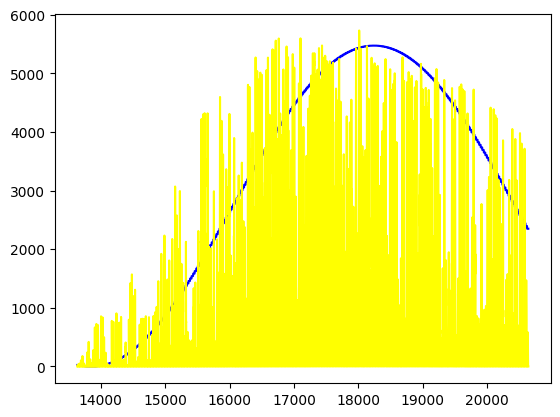

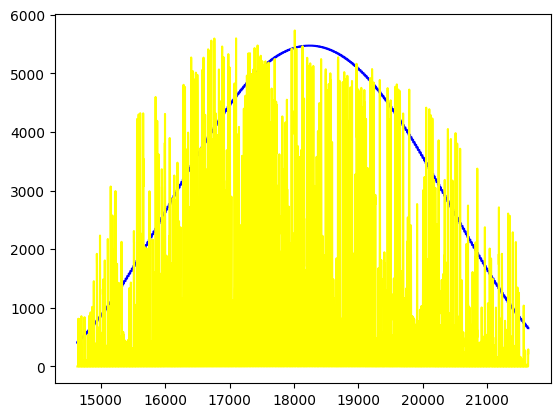

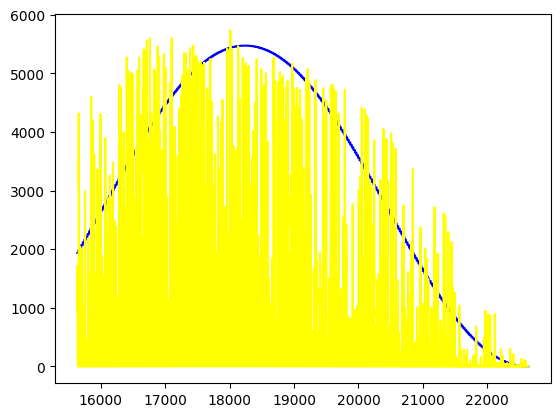

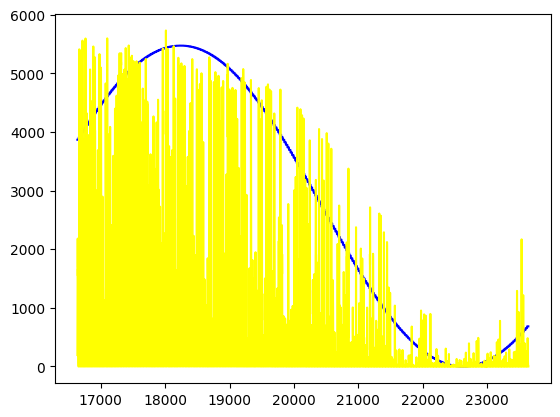

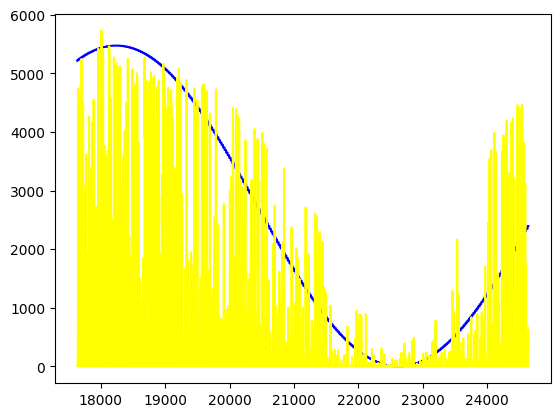

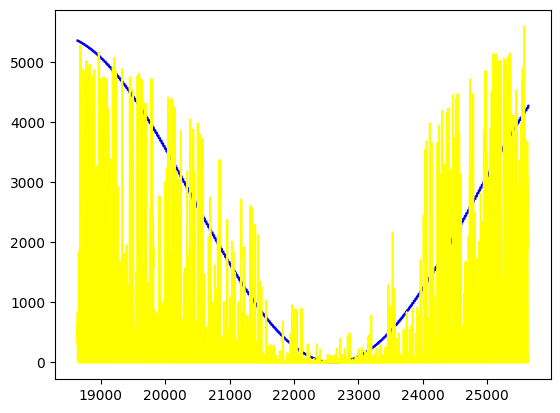

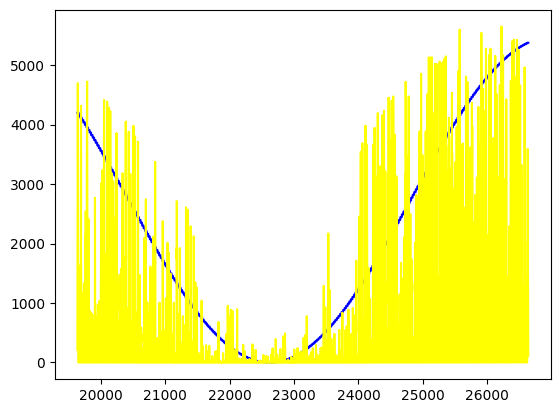

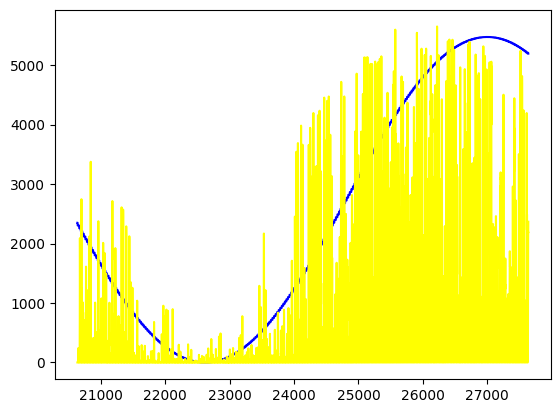

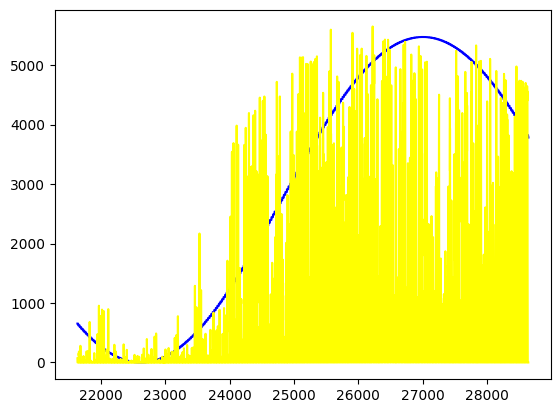

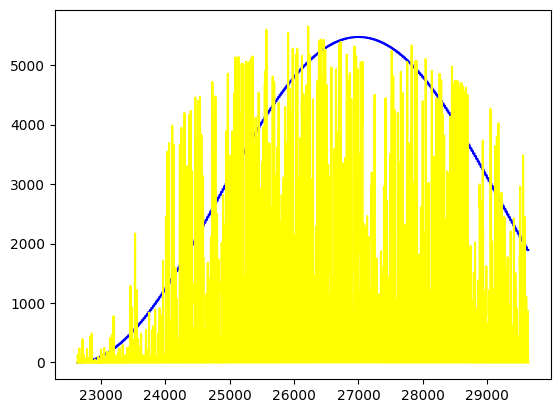

In [44]:
import matplotlib.pyplot as plt
split_X = X_train_A.iloc[all_splits_A[0][0]]
split_y = y_train_A.iloc[all_splits_A[0][1]]

print(split_X.columns)

for train, test in all_splits_A:

    plt.plot(train, 15*X_A_train['day_year'][train], c="blue")
    plt.plot(train, y_A_train[train], c="yellow")
    plt.show()

In [51]:
from catboost import CatBoostRegressor

catModel_A = CatBoostRegressor()
catModel_B = CatBoostRegressor()
catModel_C = CatBoostRegressor()

## training on the time series split 

In [45]:

from sklearn.metrics import mean_absolute_error
import pandas as pd

for train, test in (all_splits_A): 

    catModel_A.fit(X_train_A.iloc[train], y_train_A.iloc[train], silent=True, use_best_model=True, eval_set=(X_train_A.iloc[test], y_train_A.iloc[test]))

    preds_A = pd.DataFrame(catModel_A.predict(X_test_A))
    actual = y_test_A

    # preds_A = dm.scaling(preds_A, "A")
    # actual = dm.scaling(actual, "A") 

    print("CURRENT SCORING A ----->   ", mean_absolute_error(preds_A, actual))

for train, test in (all_splits_B): 

    catModel_B.fit(X_train_B.iloc[train], y_train_B.iloc[train], silent=True, use_best_model=True, eval_set=(X_train_B.iloc[test], y_train_B.iloc[test]))

    preds_B = pd.DataFrame(catModel_B.predict(X_test_B))
    actual = y_test_B

    # preds_B = dm.scaling(preds_B, "B")
    # actual = dm.scaling(actual, "B") 

    print("CURRENT SCORING B ----->   ", mean_absolute_error(preds_B, actual))

for train, test in (all_splits_C): 

    catModel_C.fit(X_train_C.iloc[train], y_train_C.iloc[train], silent=True, use_best_model=True, eval_set=(X_train_C.iloc[test], y_train_C.iloc[test]))

    preds_C = pd.DataFrame(catModel_C.predict(X_test_C))
    actual = y_test_C

    # preds_C = dm.scaling(preds_C, "C")
    # actual = dm.scaling(actual, "C") 

    print("CURRENT SCORING C ----->   ", mean_absolute_error(preds_C, actual))



CURRENT SCORING A ----->    157.67282795573914
CURRENT SCORING A ----->    167.01715296288398
CURRENT SCORING A ----->    163.52696182900092
CURRENT SCORING A ----->    158.72052211960712
CURRENT SCORING A ----->    149.61920729962497
CURRENT SCORING A ----->    162.9383651980374
CURRENT SCORING A ----->    151.02943456143922
CURRENT SCORING A ----->    148.99049707730438
CURRENT SCORING A ----->    144.1987186780806
CURRENT SCORING A ----->    147.41824111902605
CURRENT SCORING B ----->    25.890318906259896
CURRENT SCORING B ----->    26.521835879508675
CURRENT SCORING B ----->    26.64854336918785
CURRENT SCORING B ----->    28.694095562902156
CURRENT SCORING B ----->    35.529869370507726
CURRENT SCORING B ----->    30.61859468628621
CURRENT SCORING B ----->    30.17528801427116
CURRENT SCORING B ----->    30.235203449406946
CURRENT SCORING B ----->    30.11372781295125
CURRENT SCORING B ----->    27.640881722681247
CURRENT SCORING C ----->    24.587746717107485
CURRENT SCORING C -

## training on the normally split data 

In [52]:

catModel_A.fit(X_train_A, y_train_A, silent=True)
catModel_B.fit(X_train_B, y_train_B, silent=True)
catModel_C.fit(X_train_C, y_train_C, silent=True)


In [53]:
import pandas as pd 
from sklearn.metrics import mean_absolute_error
preds_A = pd.DataFrame(catModel_A.predict(X_test_A))
actual = y_test_A

# preds_A = dm.scaling(preds_A, "A")
# actual = dm.scaling(actual, "A") 

print("CURRENT SCORING A ----->   ", mean_absolute_error(actual, preds_A))

preds_B = pd.DataFrame(catModel_B.predict(X_test_B))
actual = y_test_B

# preds_B = dm.scaling(preds_B, "B")
# actual = dm.scaling(actual, "B") 

print("CURRENT SCORING B ----->   ", mean_absolute_error(actual, preds_B))

preds_C = pd.DataFrame(catModel_C.predict(X_test_C))
actual = y_test_C

# preds_C = dm.scaling(preds_C, "C")
# actual = dm.scaling(actual, "C") 

print("CURRENT SCORING C ----->   ", mean_absolute_error(actual, preds_C))



CURRENT SCORING A ----->    136.70526012804237
CURRENT SCORING B ----->    21.34572077162628
CURRENT SCORING C ----->    28.081967277112593


In [54]:
## Specify the model to be used
pred_A = catModel_A.predict(X_A_submission)
pred_B = catModel_B.predict(X_B_submission)
pred_C = catModel_C.predict(X_C_submission)

## Uncomment if normalizing data
# pred_A = dm.scaling(pred_A, "A")
# pred_B = dm.scaling(pred_B, "B")
# pred_C = dm.scaling(pred_C, "C")

test = pd.read_csv('test.csv')

df_A = pd.DataFrame()

df_A["prediction"] = pred_A
df_A["location"] = "A"

df_B = pd.DataFrame()

df_B["prediction"] = pred_B
df_B["location"] = "B"

df_C = pd.DataFrame()

df_C["prediction"] = pred_C
df_C["location"] = "C"

df_mid = pd.concat([df_A, df_B], ignore_index=True)

df = pd.concat([df_mid, df_C], join="inner", ignore_index=True)

df = df.drop("location", axis=1)


# df["id"] = test["id"]

# df = df[["id", "prediction"]]

df[df<0] = 0

# NAME THE FILE 
df.to_csv("sub63.csv")

df

,prediction
0,0.000000
1,0.000000
2,4.184380
3,64.240478
4,436.952031
...,...
2155,33.473766
2156,14.460789
2157,1.701403
2158,3.920815


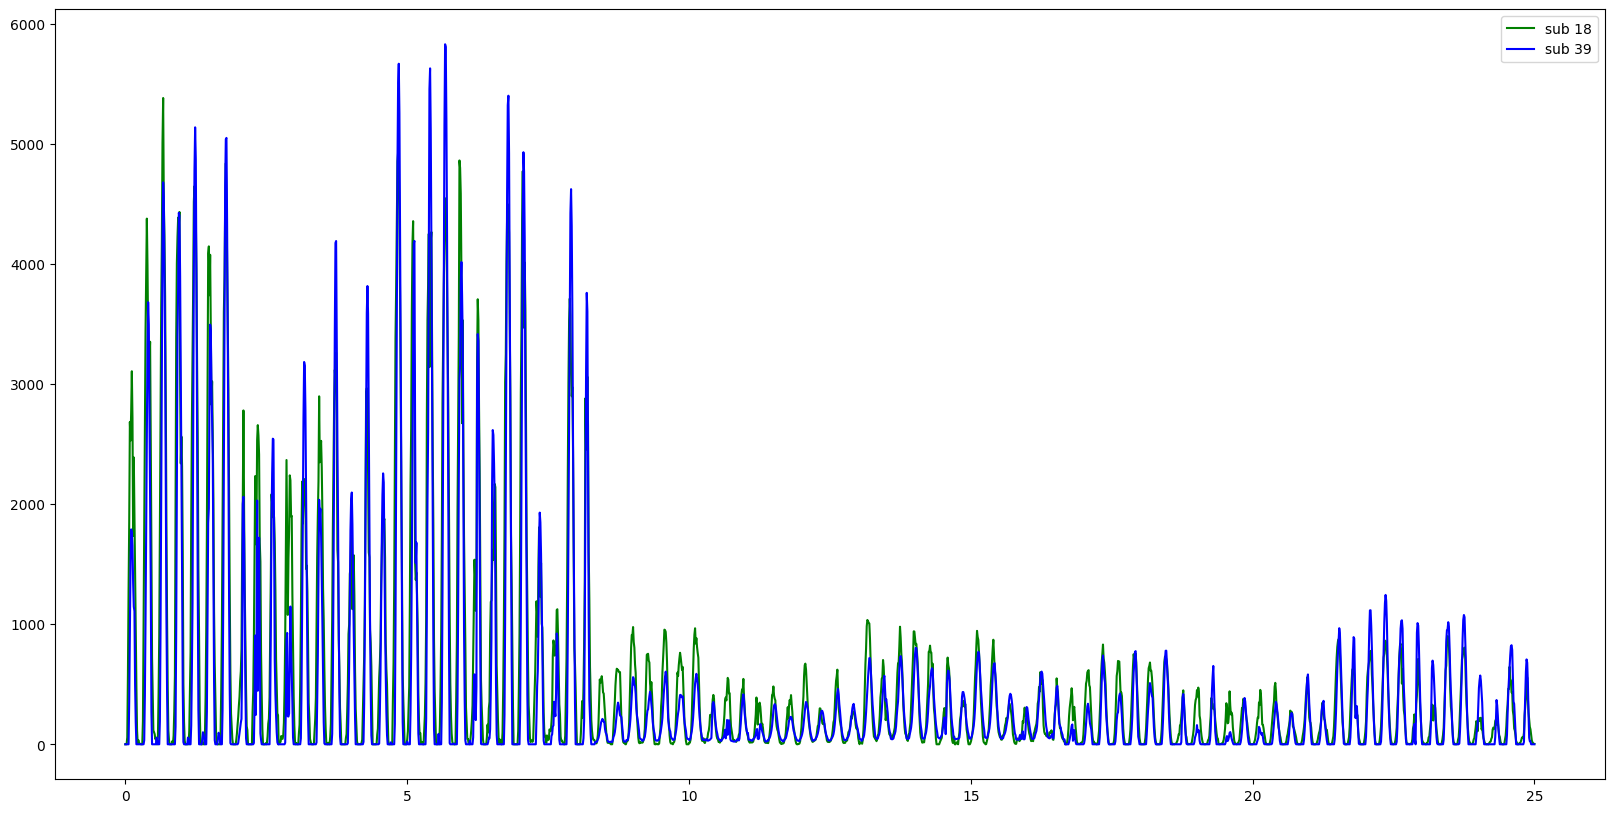

110.53349677672395


In [15]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
import pandas as pd

s18 = pd.read_csv("sub18.csv")
s39 = pd.read_csv("sub39.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub18.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 18") 

y2 = [] 
  
with open('sub39.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 39") 

plt.legend() 
plt.show() 

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(s18, s39))



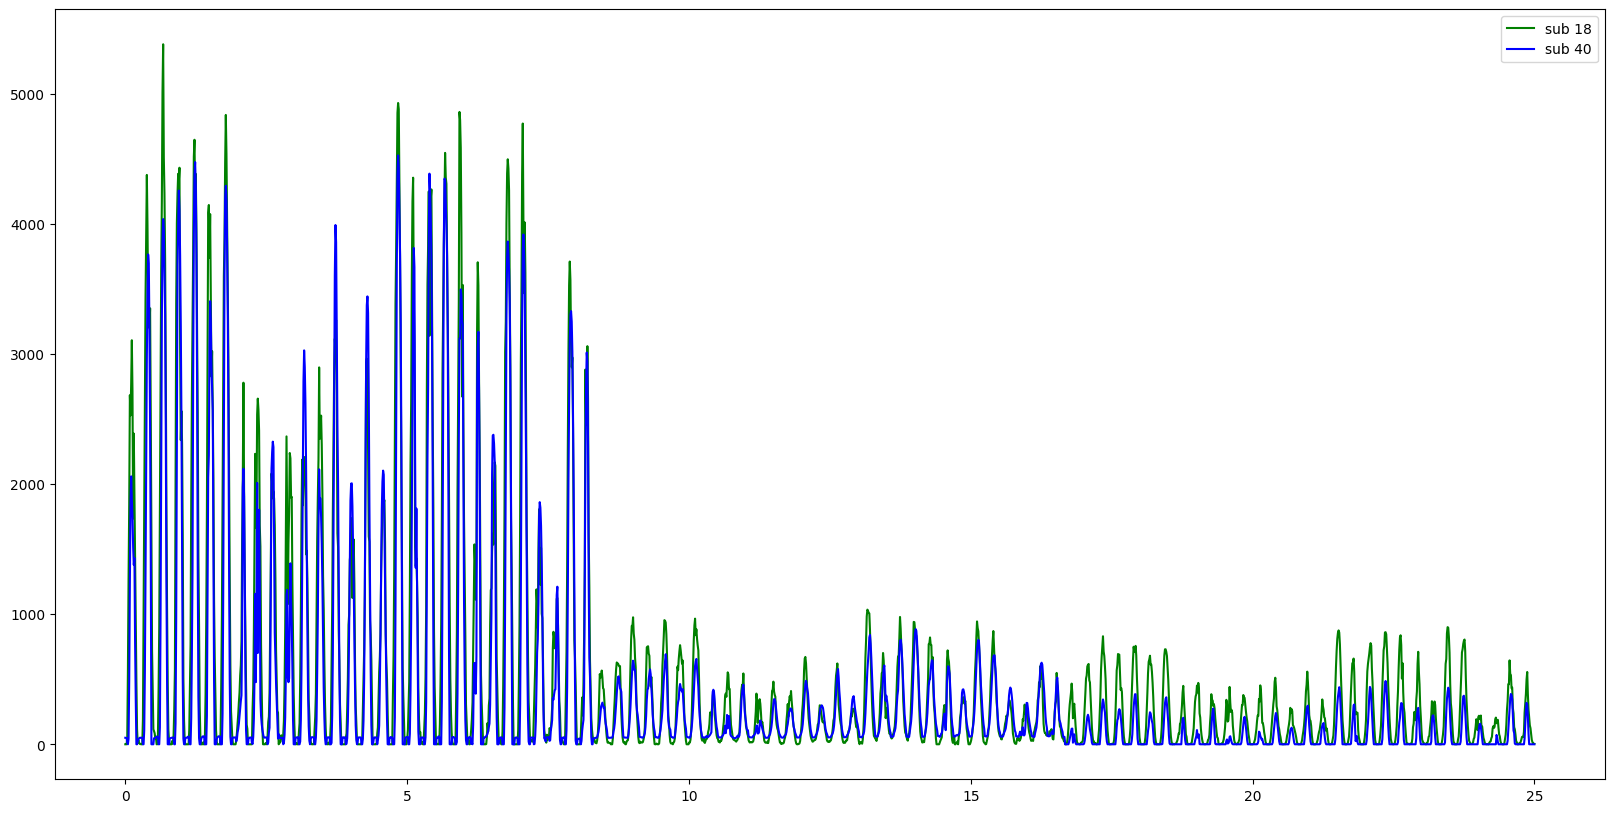

106.30018849256551


In [8]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 

s40 = pd.read_csv("sub40.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub18.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 18") 

y2 = [] 
  
with open('sub40.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 40") 

plt.legend() 
plt.show()

print(mean_absolute_error(s18, s40))

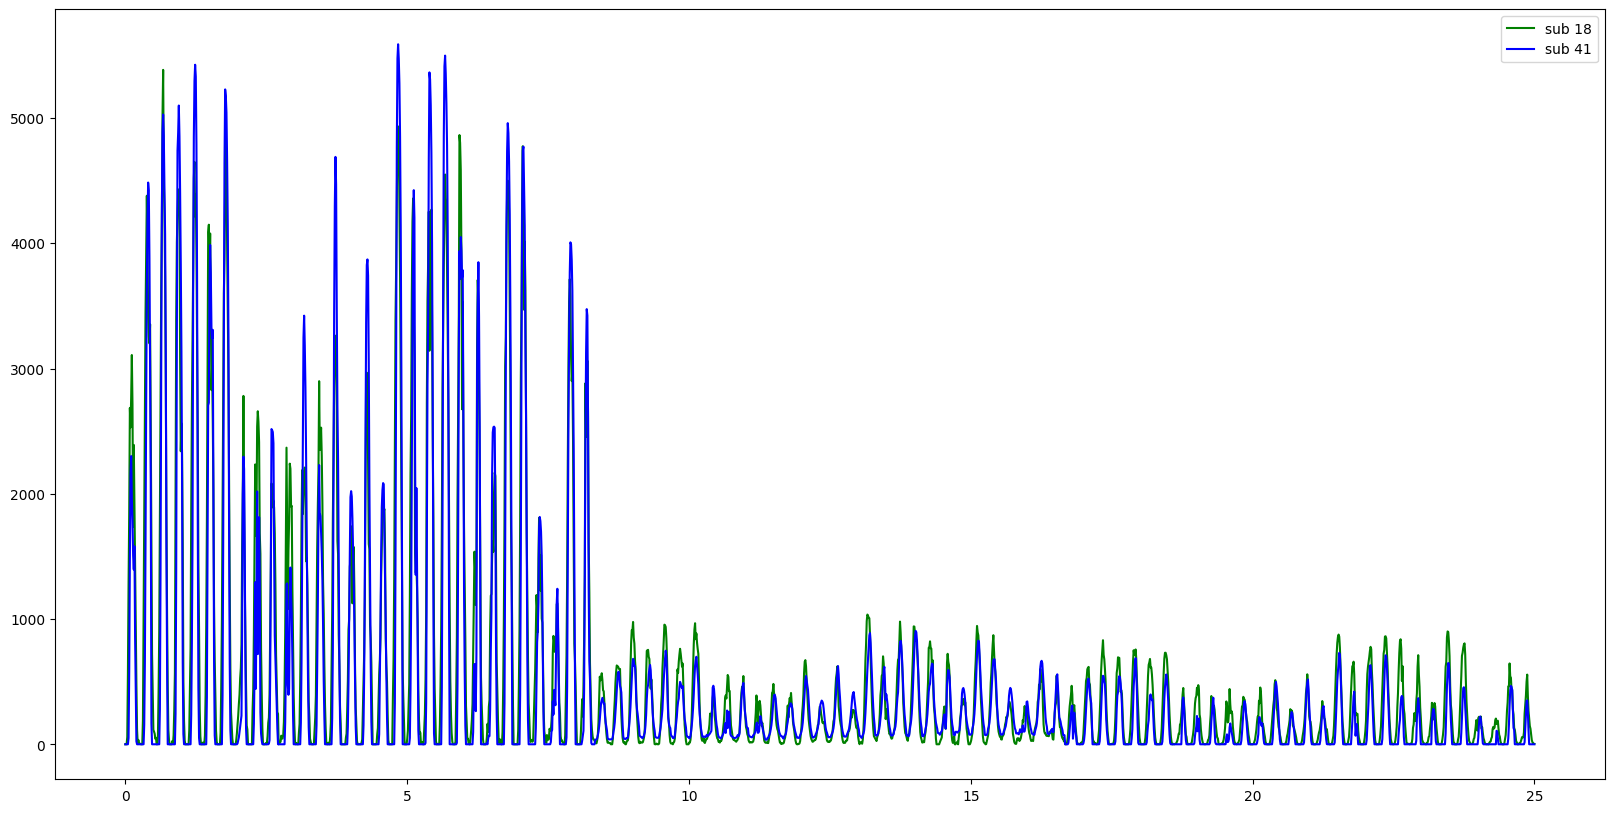

98.48684453609533


In [9]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 

s41 = pd.read_csv("sub41.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub18.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 18") 

y2 = [] 
  
with open('sub41.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 41") 

plt.legend() 
plt.show()

print(mean_absolute_error(s18, s41))

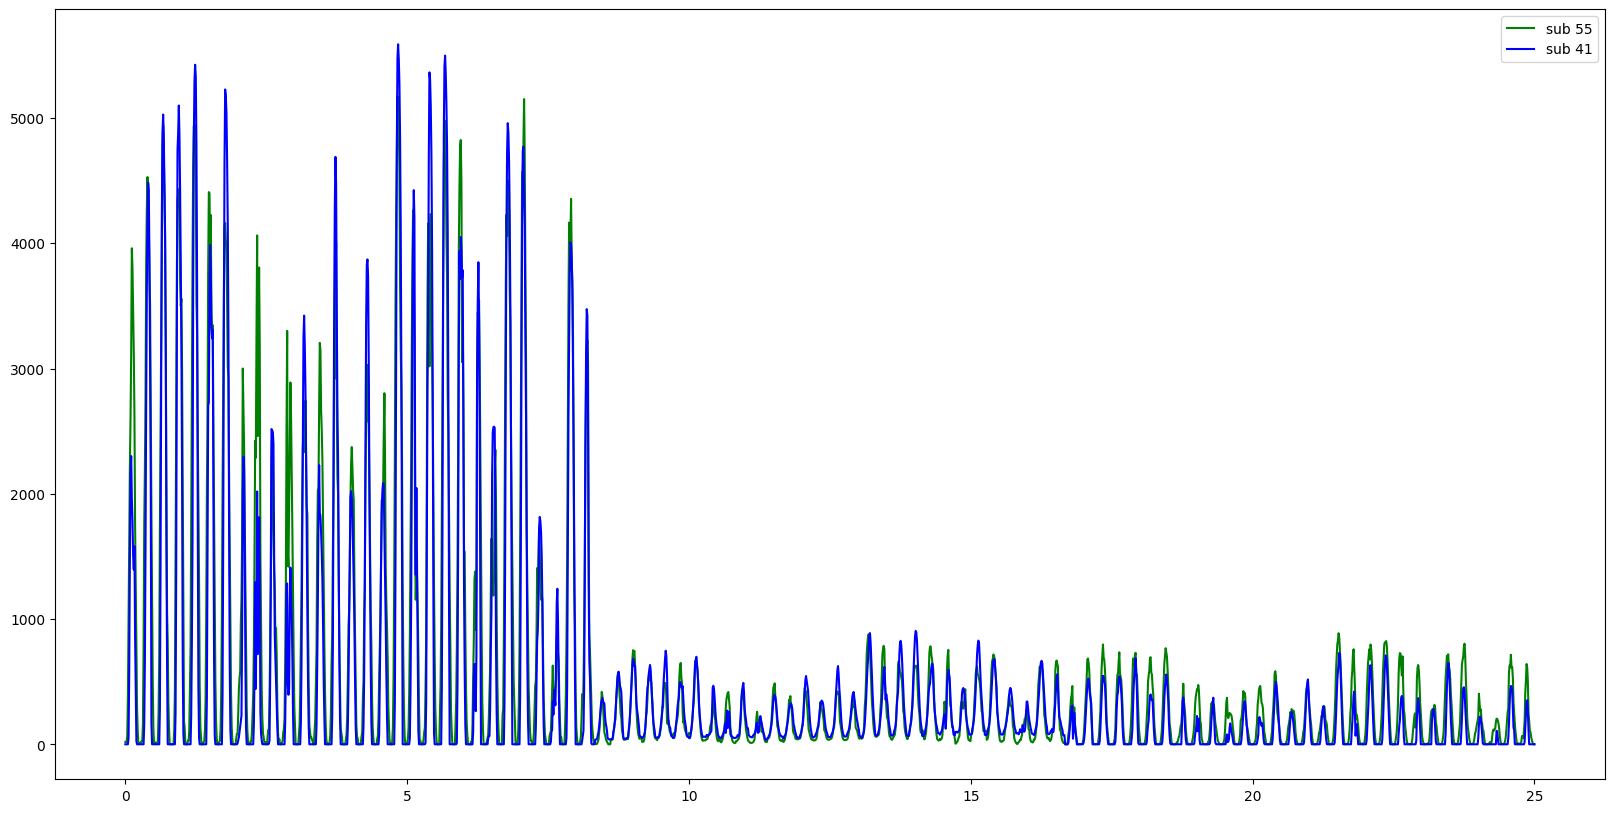

98.48684453609533


In [113]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
s55 = pd.read_csv("sub55.csv")
s52 = pd.read_csv("sub41.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub55.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 55") 

y2 = [] 
  
with open('sub41.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 41") 

plt.legend() 
plt.show()

print(mean_absolute_error(s18, s52))

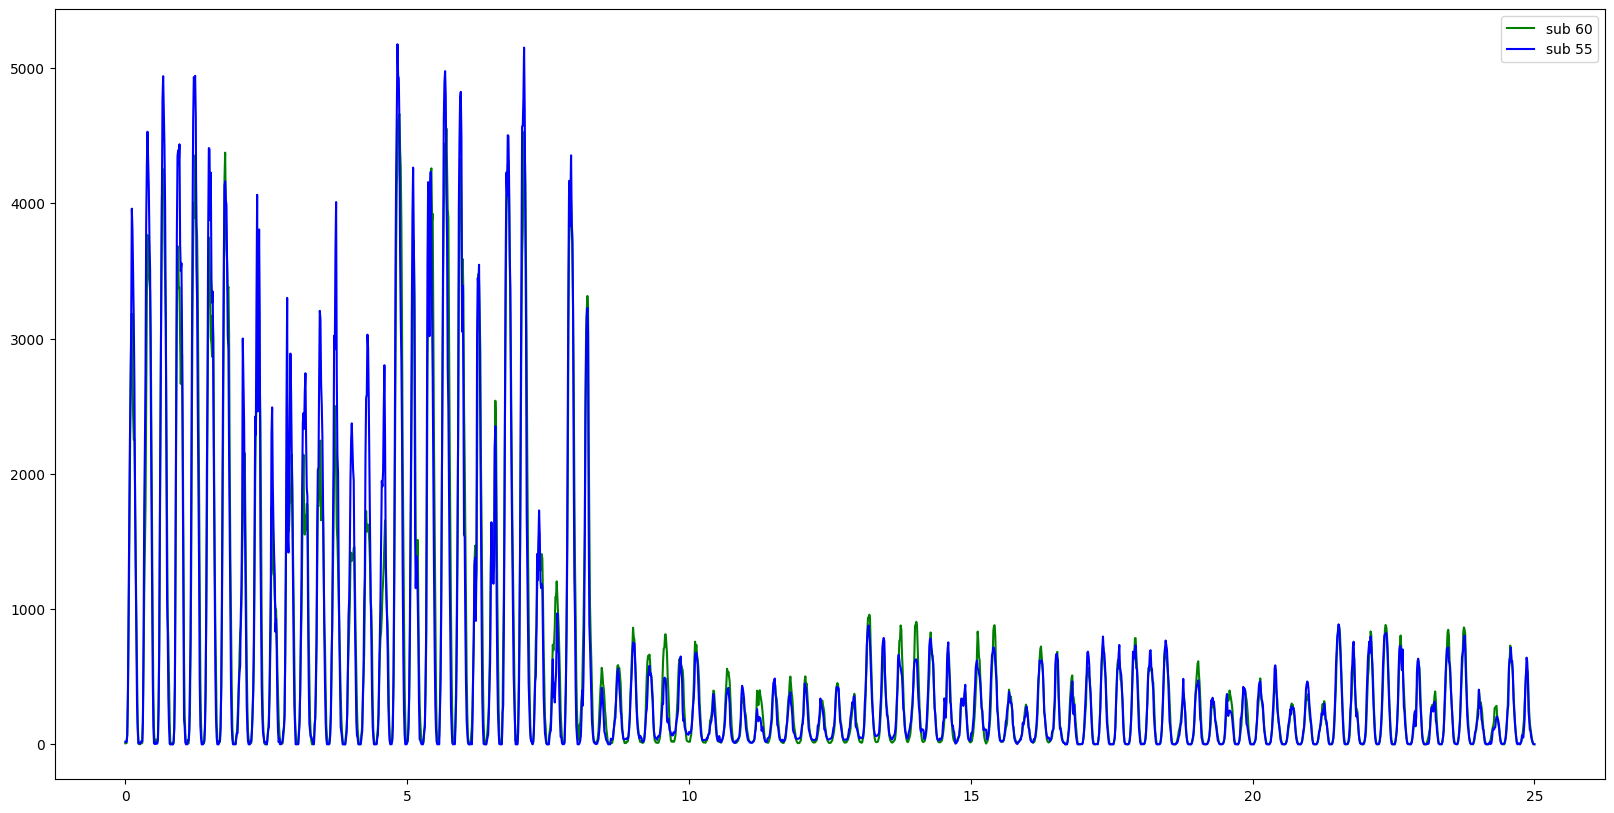

62.57833574696834


In [16]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
s60 = pd.read_csv("sub60.csv")
s55 = pd.read_csv("sub55.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub60.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 60") 

y2 = [] 
  
with open('sub55.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 55") 

plt.legend() 
plt.show()

print(mean_absolute_error(s55, s60))

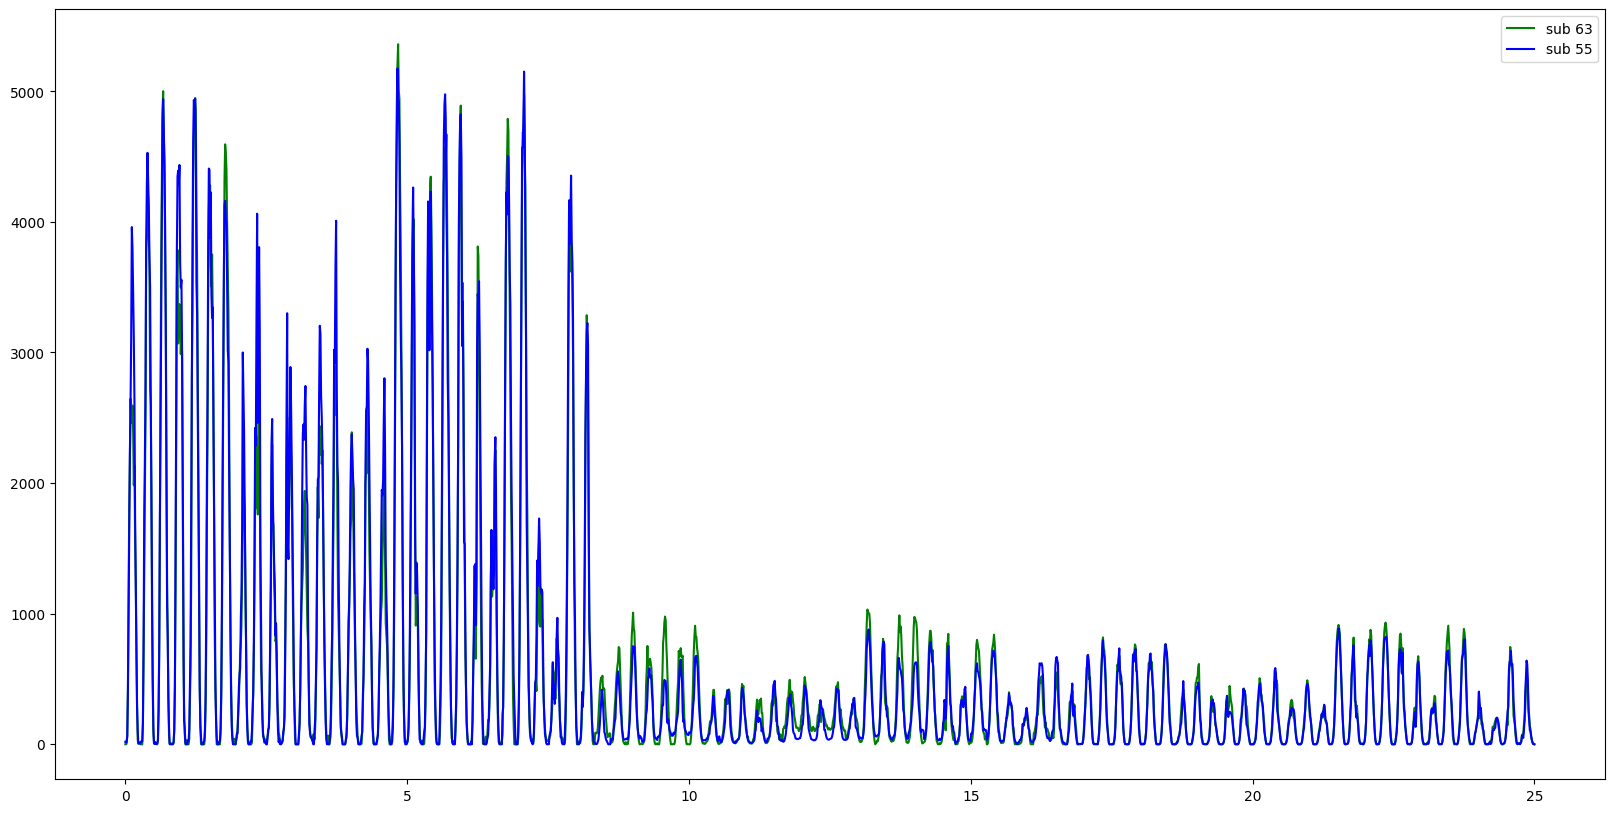

46.20638954465006


In [55]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
s60 = pd.read_csv("sub63.csv")
s55 = pd.read_csv("sub55.csv")

x = np.linspace(0, 25, 2160)
y = [] 
  
with open('sub63.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 63") 

y2 = [] 
  
with open('sub55.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
plt.plot(x, y2, color = 'b', label="sub 55") 

plt.legend() 
plt.show()

print(mean_absolute_error(s55, s60))

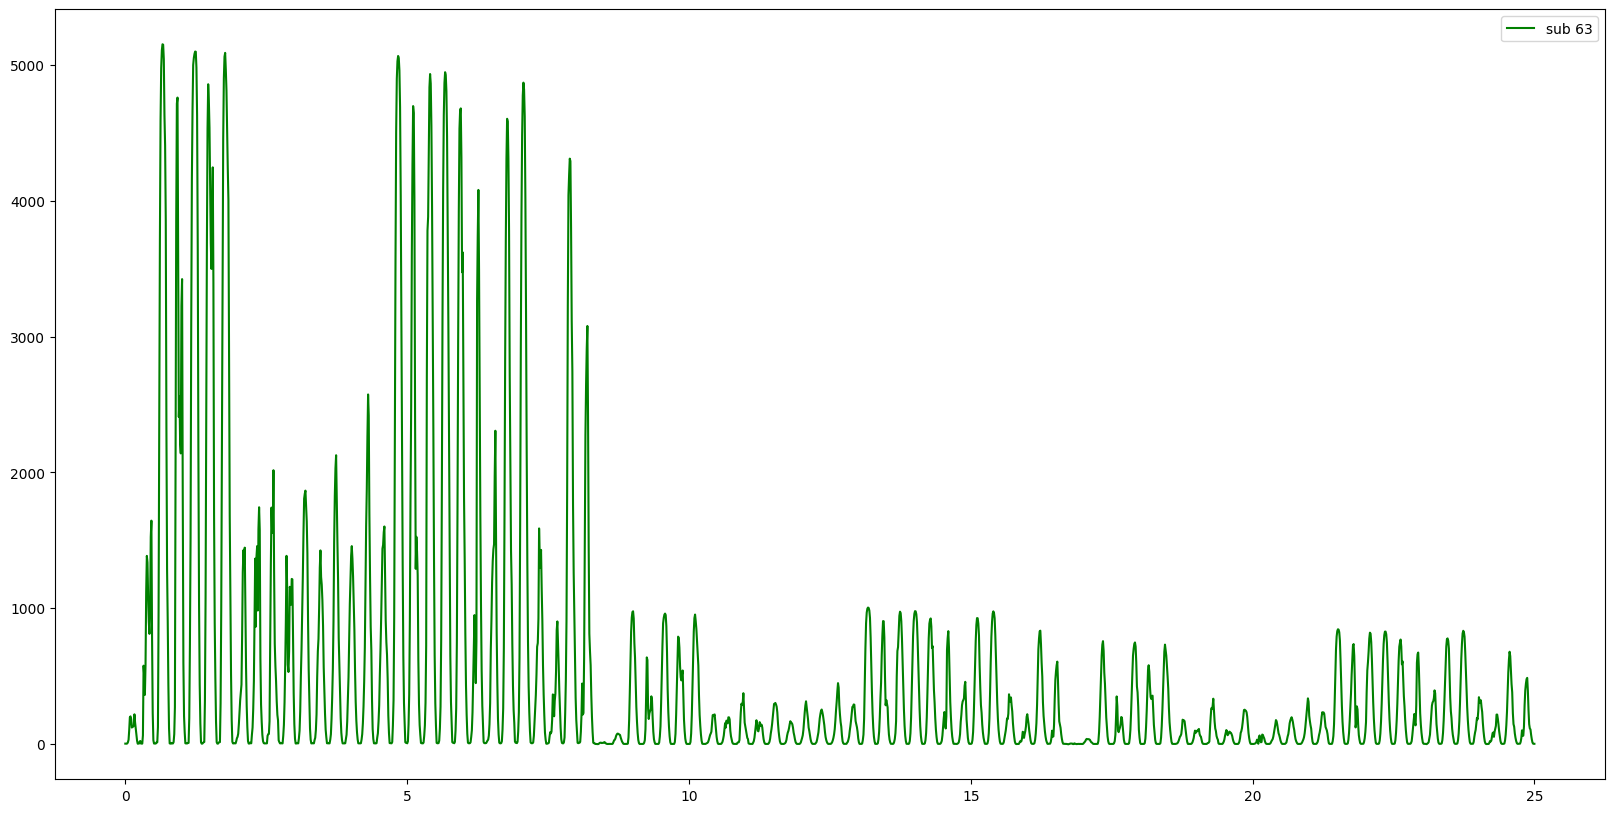

90.81416743436719


In [24]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
import pandas as pd
from sklearn.metrics import mean_absolute_error
s60 = pd.read_csv("sub80.csv")
s55 = pd.read_csv("sub55.csv")

x = np.linspace(0, 25, 3*720)
y = [] 
  
with open('sub80.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="sub 63") 

y2 = [] 
  
with open('sub55.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
#plt.plot(x, y2, color = 'b', label="sub 55") 

plt.legend() 
plt.show()

print(mean_absolute_error(s55[0*720:3*720], s60[0*720:3*720]))

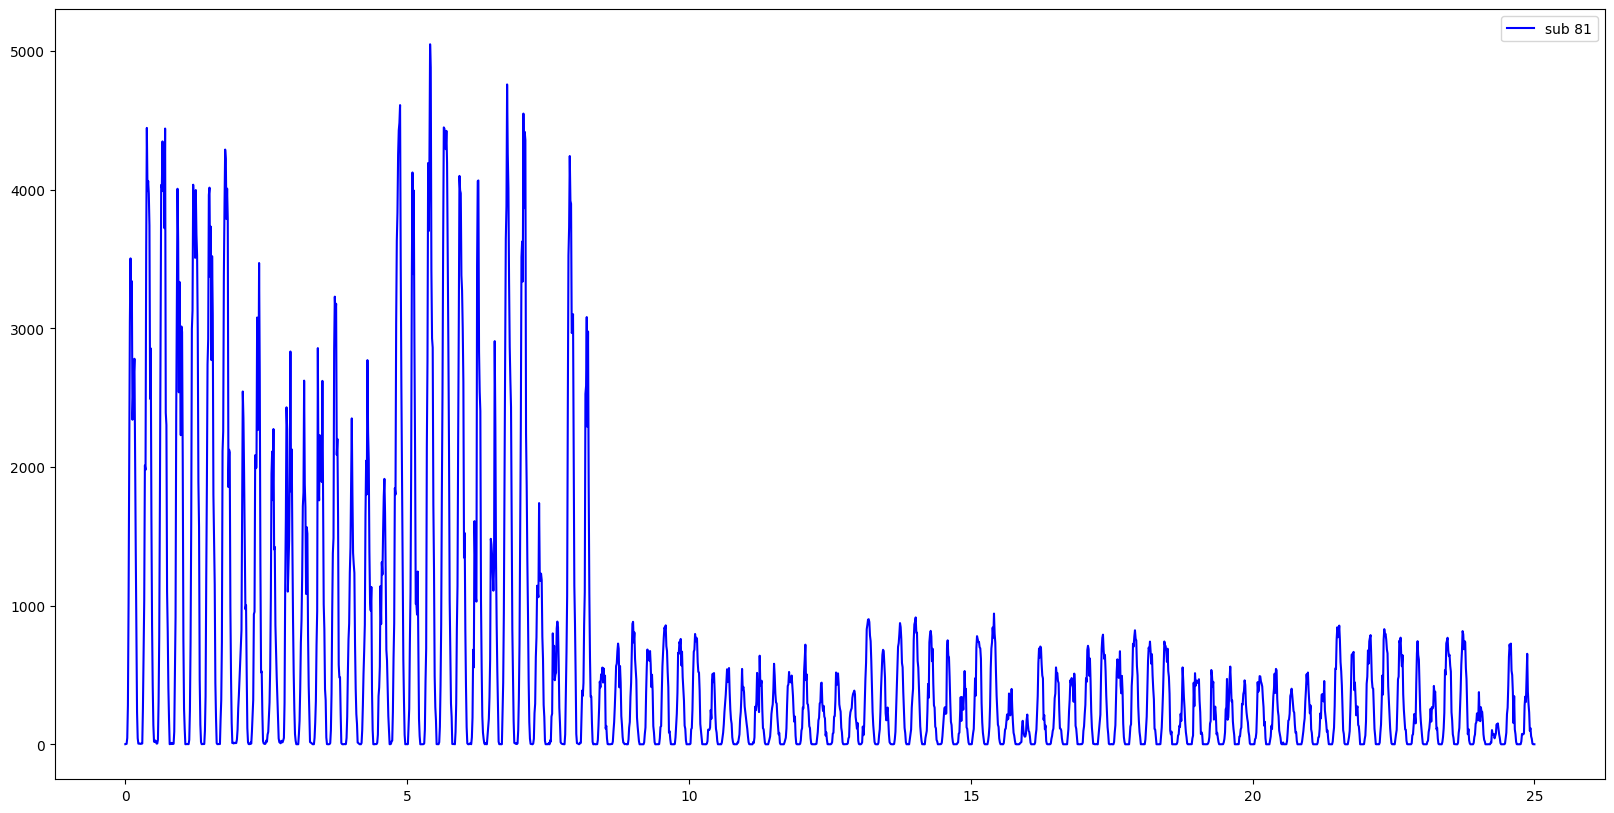

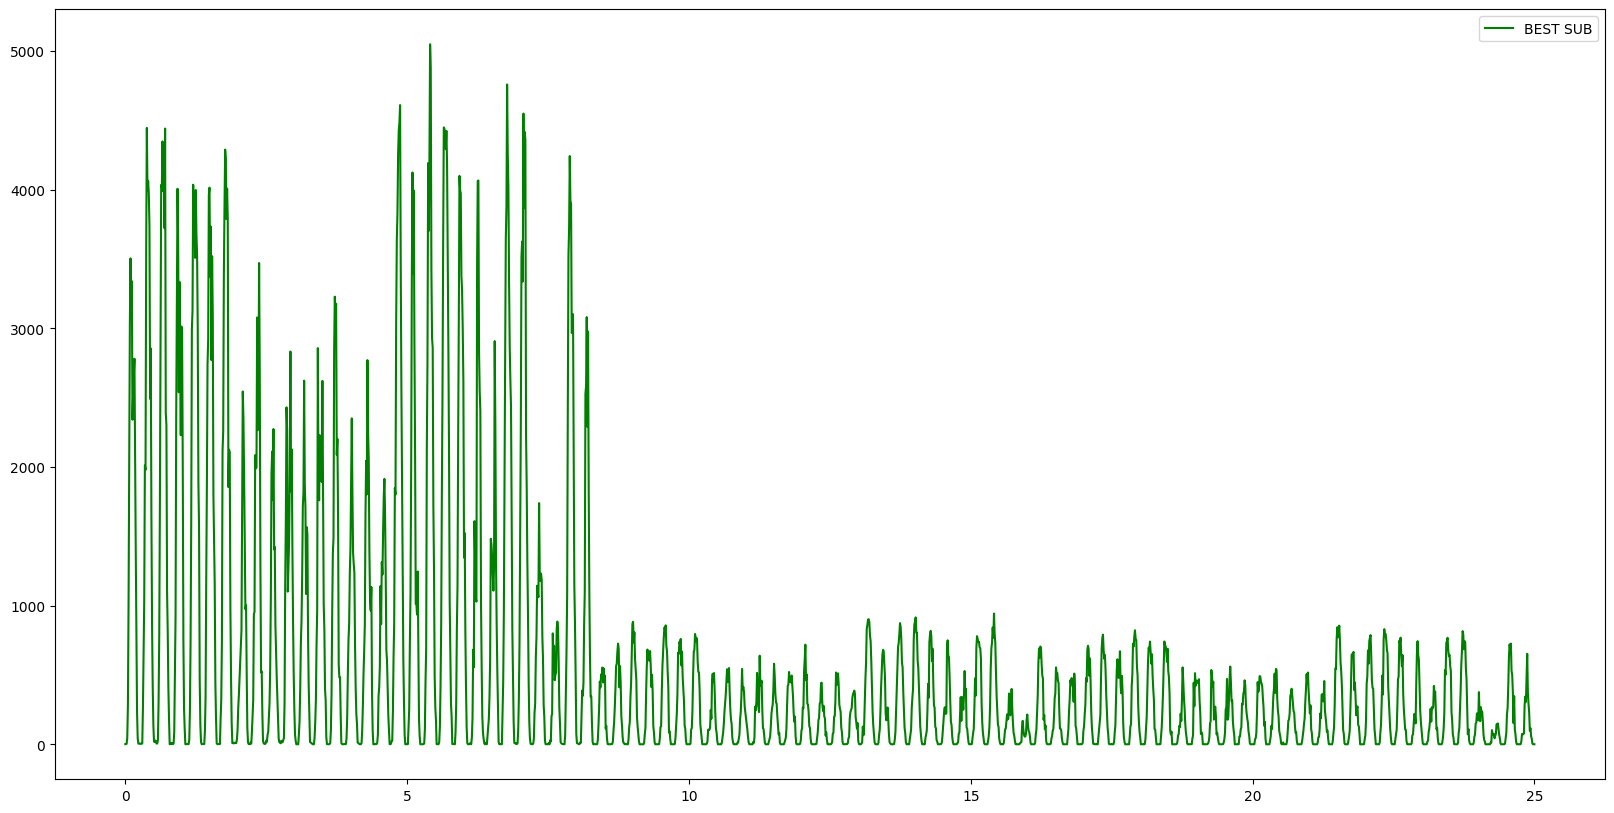

40.656517750470314
39.60431380880247
26.93752466606324
26.84170999887863


In [29]:
import matplotlib.pyplot as plt 
import csv 
import numpy as np 
import pandas as pd
from sklearn.metrics import mean_absolute_error
stack1_pred = pd.read_csv("stack_1.csv")
stack2_pred = pd.read_csv("stack_2.csv")
stack3_pred = pd.read_csv("stack_3.csv")
stack4_pred = pd.read_csv("stack_4.csv")
best_pred = pd.read_csv("log_sub_4.csv")

diff = pd.DataFrame(stack2_pred) - pd.DataFrame(best_pred)

x = np.linspace(0, 25, 3*720)
y = [] 
  
with open('stack_2.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'b', label="sub 81") 
plt.legend()


y2 = []

with open('stack_3.csv','r') as csvfile: 
    plots = csv.reader(csvfile, delimiter = ',') 

    plots.__next__()
    i = 1
      
    for row in plots: 
        y2.append(float(row[1])) 
        # i += 1

        # if ( i == 721): 
        #     break
            
        
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(x, y, color = 'g', label="BEST SUB") 
plt.legend() 
plt.show()


print(mean_absolute_error(best_pred, stack1_pred))
print(mean_absolute_error(best_pred, stack2_pred))
print(mean_absolute_error(best_pred, stack3_pred))
print(mean_absolute_error(best_pred, stack4_pred))
